In [1]:
"""Imports."""

import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

import shutil

In [12]:
"""Constants."""

data_paths = [
    'data/mahdi_v0.csv',
    'data/mahdi_vb.csv',
    'data/mahdi_vd.csv',
    'data/mahdi_ve.csv',
    'data/mahdi_vf.csv',
    'data/mahdi_vg.csv',
    'data/mahdi_vh.csv',
]

data_arrays = [
    np.genfromtxt(x, delimiter=',', dtype=str, filling_values='')
    for x in data_paths
]
data_raw = np.concatenate(data_arrays, axis=0)
labels = data_raw[:, 0]
data = data_raw[:, 1:].astype(float)

In [23]:
"""Decompose data in batches."""

batch_size = 200  # Sample rate is ~450 Hz
stride = 50
unique_labels = np.unique(labels)
data_batches = {
    label: [] for label in unique_labels
}
for i in range(0, len(data) - batch_size, stride):
    label_batch = labels[i: i + batch_size]
    if len(np.unique(label_batch)) == 1:
        data_batches[label_batch[0]].append(data[i: i + batch_size])

for k, v in data_batches.items():
    print(f'Label: {k}, num_samples: {len(v)}')

Label: , num_samples: 1272
Label: a, num_samples: 297
Label: b, num_samples: 58
Label: c, num_samples: 83
Label: d, num_samples: 67
Label: e, num_samples: 50
Label: w, num_samples: 17
Label: x, num_samples: 33
Label: z, num_samples: 23


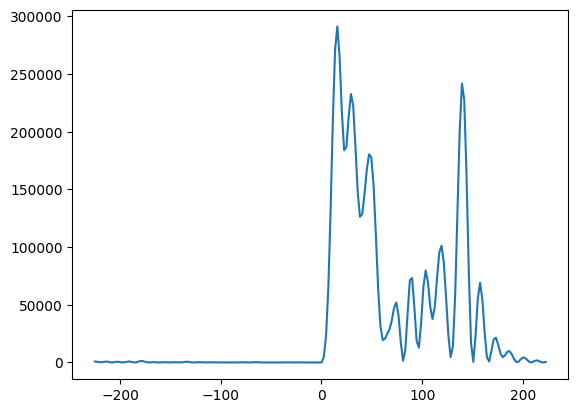

In [48]:
"""Apply feature extraction to batches."""

def _power_spectrum(x):
    x = x - np.mean(x)
    ps = np.abs(np.fft.fft(x, n=1000))**2
    # ps = np.abs(np.fft.fft(x))**2
    time_step = 1 / 450
    freqs = np.fft.fftfreq(x.size, time_step)
    idx = np.argsort(freqs)
    indices = ind[len(idx)]
    return freqs[idx], ps[idx]
    
freq, power = _power_spectrum(data_batches[''][2][:, 0])
plt.plot(freq, power)

In [46]:
len(freq)

200

In [27]:
data_batches[''].shape

AttributeError: 'list' object has no attribute 'shape'